In [ ]:
#!kill -9 -1

In [ ]:
import numpy as np
import pandas as pd
import os, json, gc, re, random
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [ ]:

#%%time


!pip uninstall -q torch -y
# 
!python3 -m pip install -q torch==1.6.0 -f https://download.pytorch.org/whl/torch_stable.html
!python3 -m pip install -q -U tokenizers==0.7.0 > /dev/null
!python3 -m pip install -q -U transformers==3.0.2 > /dev/null
!python3 -m pip install -q -U simpletransformers==0.46.0 > /dev/null


     |████████████████████████████████| 552.8MB 30kB/s 
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.6.0+cu92 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.6.0+cu92 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.6.0+cu92 which is incompatible.


In [ ]:
#!pip install torch==1.6.0 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
import torch, transformers, tokenizers
torch.__version__, transformers.__version__, tokenizers.__version__

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


('1.6.0+cu92', '3.0.2', '0.8.1.rc1')

In [ ]:
cast_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LTP/plots_masked_train.csv", delimiter = ',')
cast_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LTP/plots_masked_test.csv", delimiter = ',')
cast_valid = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LTP/plots_masked_valid.csv", delimiter = ',')


In [ ]:
cast_df.columns = ['cast','Plot']
cast_test.columns = ['cast','Plot']
cast_valid.columns = ['cast','Plot']

In [ ]:
print(cast_df.head())

   cast                                               Plot
0     0  es the old man to death. Shankar meets Bulla a...
1     6   a game of cat and mouse. Sumer loots the gran...
2     3  fell in love with him. Their marriage was fixe...
3     3  ts Venkatadri leave as he is desperate but tel...
4     1  A man was orphaned at childhood, not aware of ...


In [ ]:
cast_counts = cast_df.groupby('cast').count().iloc[:,0]

In [ ]:
print(cast_counts)

cast
0     74
1     88
2    100
3    158
4    145
5     68
6     71
7     69
8    146
9    132
Name: Plot, dtype: int64


In [ ]:
#!python3 -m pip install simpletransformers

In [ ]:
from simpletransformers.classification import ClassificationModel

model_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "save_model_every_epoch": False,
    "save_eval_checkpoints": False,
    "use_cuda" : True,
    "max_seq_length": 512,
    "train_batch_size": 10,
    "num_train_epochs": 15,
}

# Create a ClassificationModel
# model = ClassificationModel("roberta", "roberta-base", num_labels=len(cast_counts), args=model_args)
model = ClassificationModel("longformer", "allenai/longformer-base-4096", num_labels=len(cast_counts), args=model_args)
#model = ClassificationModel('roberta', 'roberta-base', num_labels=len(cast_counts), args=model_args)
# model = ClassificationModel("xlnet", "xlnet-base-cased", num_labels=len(cast_counts), args=model_args)


INFO:filelock:Lock 140161666235472 acquired on /root/.cache/torch/transformers/ea6da73c9ecf0c07b29510e423dfd58f1b8b59cba3c89383189ec8b0b6d00e82.eac3423747595976f3a9edff0a11b53ff7005ed92d70f39106dcb04b8871ee74.lock


INFO:filelock:Lock 140161666235472 released on /root/.cache/torch/transformers/ea6da73c9ecf0c07b29510e423dfd58f1b8b59cba3c89383189ec8b0b6d00e82.eac3423747595976f3a9edff0a11b53ff7005ed92d70f39106dcb04b8871ee74.lock


INFO:filelock:Lock 140161666235472 acquired on /root/.cache/torch/transformers/dfc92dbbf5c555abf807425ebdb22b55de7a17e21fe1c48cbaa5764982c1d9c0.cd65234711d2e83d420aa696eb9186cdec6ab79ef8bf090b442cf249443dfa92.lock


INFO:filelock:Lock 140161666235472 released on /root/.cache/torch/transformers/dfc92dbbf5c555abf807425ebdb22b55de7a17e21fe1c48cbaa5764982c1d9c0.cd65234711d2e83d420aa696eb9186cdec6ab79ef8bf090b442cf249443dfa92.lock


- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:filelock:Lock 140159586944656 acquired on /root/.cache/torch/transformers/1ae1f5b6e2b22b25ccc04c000bb79ca847aa226d0761536b011cf7e5868f0655.ef00af9e673c7160b4d41cfda1f48c5f4cba57d5142754525572a846a1ab1b9b.lock


INFO:filelock:Lock 140159586944656 released on /root/.cache/torch/transformers/1ae1f5b6e2b22b25ccc04c000bb79ca847aa226d0761536b011cf7e5868f0655.ef00af9e673c7160b4d41cfda1f48c5f4cba57d5142754525572a846a1ab1b9b.lock


INFO:filelock:Lock 140159553498960 acquired on /root/.cache/torch/transformers/f8f83199a6270d582d6245dc100e99c4155de81c9745c6248077018fe01abcfb.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda.lock


INFO:filelock:Lock 140159553498960 released on /root/.cache/torch/transformers/f8f83199a6270d582d6245dc100e99c4155de81c9745c6248077018fe01abcfb.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda.lock


In [ ]:
train_df = cast_df
eval_df = cast_test

# Train the model
model.train_model(train_df[["Plot", "cast"]])

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df[["Plot", "cast"]])
print(result)



INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f79b0db4b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f79b0db4b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f79b0db4b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f79b0db4b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f79b0db4b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeo

INFO:simpletransformers.classification.classification_model: Training of longformer model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


INFO:simpletransformers.classification.classification_model:{'mcc': 0.5445739642471589, 'eval_loss': 1.8911875301883334}



{'mcc': 0.5445739642471589, 'eval_loss': 1.8911875301883334}


In [ ]:

predicted_genres_encoded = list(map(lambda x: np.argmax(x), model_outputs))
print(predicted_genres_encoded)

[9, 8, 7, 5, 6, 4, 4, 8, 1, 3, 9, 8, 9, 9, 8, 3, 3, 9, 9, 8, 3, 6, 2, 7, 3, 9, 3, 8, 0, 4, 4, 5, 6, 1, 8, 0, 7, 6, 3, 0, 0, 4, 6, 4, 9, 3, 8, 3, 9, 7, 5, 6, 8, 3, 3, 2, 9, 8, 7, 8, 3, 8, 6, 5, 6, 6, 5, 2, 9, 5, 2, 4, 8, 3, 3, 9, 8, 8, 0, 0, 8, 2, 0, 7, 8, 7, 8, 8, 1, 9, 9, 3, 6, 0, 0, 7, 7, 3, 6, 2, 9, 1, 4, 1, 3, 8, 2, 7, 4, 6, 2, 6, 9, 2, 8, 4, 5, 5, 2, 4, 8, 0, 8, 7, 3, 4, 8, 2, 4, 9, 2, 2, 0, 5, 4, 4, 3, 2, 7, 2, 0, 1, 9, 8, 3, 8, 7, 6, 3, 0, 0, 8, 7, 0, 9, 8, 7, 6, 2, 6, 9, 4, 9, 5, 3, 9, 3, 0, 3, 8, 9, 0, 6, 4, 0, 8, 9, 4, 8, 9, 3, 0, 0, 0, 2, 5, 5, 7, 4, 9, 6, 5, 4, 7, 5, 4, 4, 3, 2, 1, 0, 3, 3, 2, 8, 4, 4, 9, 8, 5, 3, 8, 3, 6, 4, 9, 4, 4, 0, 8, 7, 3, 3, 0, 3, 3, 7, 8, 8, 3, 2, 1, 4, 4, 8, 2, 1, 1, 4, 9, 2, 1, 4, 2, 8, 8, 1, 4, 3, 1, 7, 0, 6, 0, 2, 5, 5, 0, 3, 4, 2, 0, 4, 2, 9, 3, 8, 4, 8, 5, 3, 9, 8, 0, 7, 0, 0, 2, 7, 0, 4, 2, 0, 3, 3, 3, 2, 7, 8, 1, 5, 2, 3, 8, 3, 1, 3, 0, 4, 9, 3, 1, 0, 5, 7, 8, 0, 9, 8, 9, 1, 6, 8, 8, 6, 1, 2, 4, 2, 6, 6, 8, 4, 0, 2, 5, 2, 3, 6]


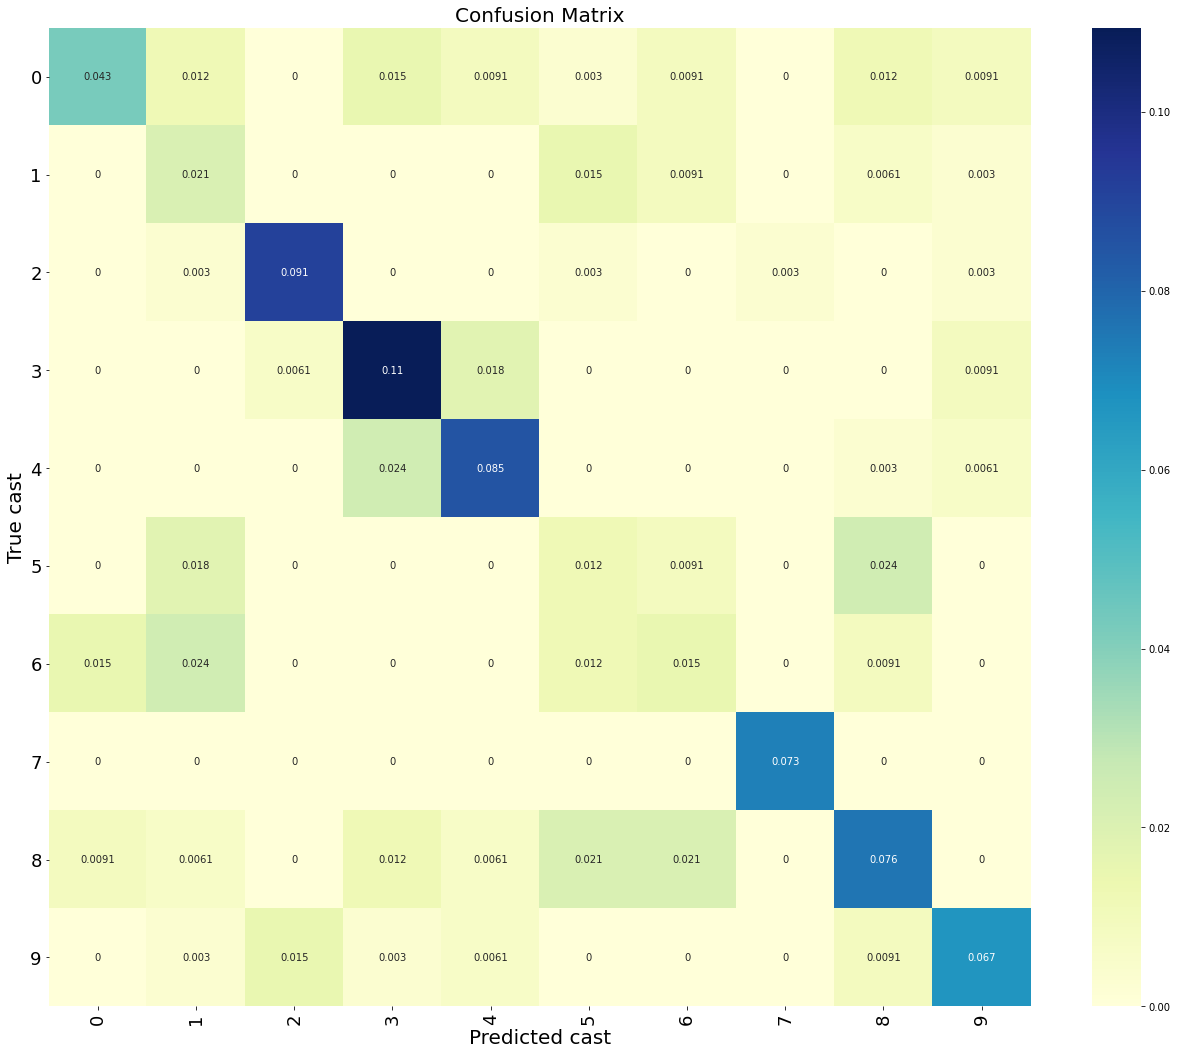

In [ ]:

label_encoder = LabelEncoder()

predicted_genres = list(map(lambda x: np.argmax(x), model_outputs))
eval_gt_labels = eval_df["cast"].tolist()
class_labels = list(range(len(cast_counts)))


plt.figure(figsize=(22,18))
cf_matrix = confusion_matrix(predicted_genres, eval_gt_labels, class_labels)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, cmap="YlGnBu")
ax.set_xlabel('Predicted cast', fontsize=20)
ax.set_ylabel('True cast', fontsize=20)
ax.set_title('Confusion Matrix', fontsize=20)
ax.set_xticklabels(class_labels, rotation=90, fontsize=18)
ax.set_yticklabels(class_labels, rotation=0, fontsize=18)

plt.show()

In [ ]:
random_idx = random.randint(0, len(eval_df)-1)
text = eval_df.iloc[random_idx]['Plot']
true_genre = eval_df.iloc[random_idx]['cast']

# Predict with trained multiclass classification model
predicted_genres_example, raw_outputs = model.predict([text])
predicted_genres_example = np.array(predicted_genres_example)

print(f'\nTrue Genre:'.ljust(16,' '), f'{true_genre}\n')
print(f'Predicted Genre: {predicted_genres_example[0]}\n')
print(f'Plot: {text}\n')
print("-------------------------------------------")

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.




True Genre:     2

Predicted Genre: 2

Plot: ays tries to one up Periya Thevar, it puts them at loggerheads with each other.
Saktivelu spends time in the village with his girlfriend by re-visiting his childhood memories. They come across an old temple which has been closed off on Maya Thevar’s instructions. He insists on entering and his friend and servant Esaki (Vadivelu) breaks open the lock for them to look around. Maya Thevar hears of this and a brutal riot is started among the two village factions. Periya Thevar, in order to quell the situation, contemplates on apologising to his opponents. Sakthivelu feels it should be him or Esaki who should apologise. When Saktivelu asks for Esaki, he learns that Maya Thevar has cut off Esaki’s hand as punishment for opening the temple. To prevent further escalation of the situation Saktivelu, with permission from his father, enlists the help of his friends in the government and opens the temple for all legally. Slighted by this, Maya Thevar 

In [ ]:
print(len(predicted_genres))
print(len(eval_gt_labels))

329
329


In [ ]:
num = 0
den = 0
for i in range(len(eval_gt_labels)):
  if predicted_genres[i] == eval_gt_labels[i]:
    num += 1
  den += 1

print(num/den)

0.5927051671732523
